# Writing Our Own Backward Pass

## What We Have So Far

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

### Build Vocabulary

In [2]:
words = open('../data/names.txt', 'r').read().splitlines()

In [3]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


### Build Dataset

In [4]:
block_size = 3

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [5]:
def compare(label, dt, t):
  """Compare gradients calculated by Pytorch and our manual calculation"""
  ex = torch.all(dt==t.grad).item()
  app = torch.allclose(dt, t.grad)
  maxdiff = (dt-t.grad).abs().max().item()
  print(f'{label:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}')

### Init Params

There are a couple of things to notice in our initialization:

1. We are initializing many of the params in a non-standard way(normally biases are all zeros). We're doing this because we'll be calculating our gradients manually and sometimes when our params are initialized to zero, they can mask an incorrect implementation of the gradient. To counteract this possibility we have initialized our params to small numbers.

2. We are using B1 even though it'll get cancelled out because of batch norm. This is here just for fun. We'll be able to calculate the gradient with respect to it can check that it's working properly.

In [6]:
n_embd = 10
n_hidden = 64

C  = torch.randn((vocab_size, n_embd))
# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden)) * (5/3)/((n_embd * block_size)**0.5)
B1 = torch.randn(n_hidden) * 0.1 # useless because of BN
# Layer 2
W2 = torch.randn((n_hidden, vocab_size)) * 0.1
B2 = torch.randn(vocab_size) * 0.1
# BatchNorm parameters
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1

parameters = [C, W1, B1, W2, B2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))
for p in parameters:
  p.requires_grad = True

4137


### Create A Batch

In [7]:
batch_size = 32
n = batch_size

ix = torch.randint(0, Xtr.shape[0], (batch_size,))
Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

### Forward Pass

Since we'll manually go backwards through the forward pass to calculate the gradients, we have used more intermediate tensors.

In [8]:
emb = C[Xb]
embcat = emb.view(emb.shape[0], -1)
# Linear layer 1
hprebn = embcat @ W1 + B1
# BatchNorm layer
bnmeani = 1/n*hprebn.sum(0, keepdim=True)
bndiff = hprebn - bnmeani
bndiff2 = bndiff**2
bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n)
bnvar_inv = (bnvar + 1e-5)**-0.5
bnraw = bndiff * bnvar_inv
hpreact = bngain * bnraw + bnbias
# Non-linearity
h = torch.tanh(hpreact)
# Linear layer 2
logits = h @ W2 + B2
# cross entropy loss (same as F.cross_entropy(logits, Yb))
logit_maxes = logits.max(1, keepdim=True).values
norm_logits = logits - logit_maxes # subtract max for numerical stability
counts = norm_logits.exp()
counts_sum = counts.sum(1, keepdims=True)
counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
probs = counts * counts_sum_inv
logprobs = probs.log()
loss = -logprobs[range(n), Yb].mean()

# PyTorch backward pass
for p in parameters:
  p.grad = None
for t in [logprobs, probs, counts, counts_sum, counts_sum_inv,
          norm_logits, logit_maxes, logits, h, hpreact, bnraw,
         bnvar_inv, bnvar, bndiff2, bndiff, hprebn, bnmeani,
         embcat, emb]:
  t.retain_grad()
loss.backward()
loss

tensor(3.3032, grad_fn=<NegBackward0>)

## Backpropagating Through Line By Line Through Forward Pass

**`logprobs`**

We are prepending derivatives of variables above with a `d`. For example derivative of `logprobs` is `dlogprobs`. `dlogprobs` is the gradient of the loss w.r.t to all the `logprobs` of the tensor.

In [11]:
logprobs.shape

torch.Size([32, 27])

In [12]:
Yb

tensor([21, 18, 25,  0,  0, 14, 20,  7, 14, 14,  0,  1, 14,  1,  8, 14, 14,  0,
        12, 25,  1, 15, 15,  5, 14, 12, 18, 19,  5, 20, 19, 14])

`logprobs` is of `dim=(32, 27)` so it's derivative will also be of the same size i.e. `dim=(32, 27)`.

In [9]:
loss = -logprobs[range(n), Yb].mean()

In [10]:
logprobs[range(n), Yb]

tensor([-3.5060, -2.7486, -2.4663, -3.0699, -3.2036, -2.4438, -3.5328, -3.2617,
        -3.0439, -3.8202, -2.7486, -3.0359, -4.2181, -3.6518, -3.8510, -3.3660,
        -4.0383, -3.0685, -2.7486, -3.3178, -3.4971, -3.4755, -3.1675, -3.6001,
        -3.4447, -3.0768, -1.8435, -4.2654, -3.2072, -3.7865, -4.0949, -3.1025],
       grad_fn=<IndexBackward0>)

To calculate the loss we pluck out `logprobs` at indices `Yb`(the probability for the correct next char in the sequence) and calculate their mean. Which means:
`loss = -(a + b + c) / 3.`
`loss = -1/3a + -1/3b + -1/3c`
`dloss / da = -1/3`

So if we have n numbers instead of 3 then `dloss / d(n)` will be `-1/n`. So `dloss / dlogprobs = -1/n` where `n` is the `batch_size`.

`logprobs` is `(32, 27)` but only 32 of them participate in the loss calculation so what is the derivative for the other values? Their gradient is 0 because they don't participate in the loss. If we were to change these numbers, the loss wouldn't change.

In [12]:
dlogprobs = torch.zeros_like(logprobs) # Create a tensor in shape of logprobs
dlogprobs[range(n), Yb] = -1.0 / n # Gradient of the relevant n values for a given batch

Let's check if our gradient is correct.

In [15]:
compare('logprobs', dlogprobs, logprobs)

logprobs        | exact: True  | approximate: True  | maxdiff: 0.0


**`probs`**

`logprobs` depend on `probs` through a log function.

`logprobs = probs.log()`

So we are taking the element-wise log of all the probabilities. So the derivative of probs -> log -> logprobs will be:

In [13]:
dprobs = (1.0 / probs) * dlogprobs # chain the derivative of output

In [17]:
compare('probs', dprobs, probs)

probs           | exact: True  | approximate: True  | maxdiff: 0.0


Looking at the derivative of probs we can see that if the network predicts the next character exactly correct probability is 1 and `dprobs` just becomes `dlogprobs`. But if the probability is low than 1 then `dlogprobs` will get boosted by the factor `1/prob`. So this part is boosting the gradients for the samples which have low probs assigned to the correct character.

**`dcounts_sum_env`**

Here's what's happening after we take our logits:

In [ ]:
logits = h @ W2 + B2
logit_maxes = logits.max(1, keepdim=True).values
norm_logits = logits - logit_maxes
counts = norm_logits.exp()
counts_sum = counts.sum(1, keepdims=True)
counts_sum_inv = counts_sum**-1
probs = counts * counts_sum_inv

We are finding the max in each row of the logits and subtracting it to achieve numerical stability because if we don't do this some of the counts take too large values when we exponentiate the logits. Then we take the sum of our counts and normalise them to get the probabilities. So the derivative of `dcounts_sum_inv` will be:

In [18]:
counts.shape, counts_sum_inv.shape

(torch.Size([32, 27]), torch.Size([32, 1]))

Since the shapes don't match, Pytorch will perform the broadcasting operation when we perform `probs = counts * counts_sum_inv`.

`c = a * b` where `a[3,3]` and `b[3,1]`
`c =` 
`a11xb1 a12xb1 a13xb1`
`a21xb2 a22xb2 a33xb2`
`a31xb3 a32xb3 a33xb3` to get `c[3,3]`

So pytorch applied two operations to complete this step during the forward pass, replication and then multiplication.

In [14]:
dcounts_sum_inv = counts * dprobs # Backprop through multiplication

In [15]:
dcounts_sum_inv = (counts * dprobs).sum(1, keepdim=True) # Backprop through replication

In [21]:
compare('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)

counts_sum_inv  | exact: True  | approximate: True  | maxdiff: 0.0


**`counts`**

In [16]:
dcounts = counts_sum_inv * dprobs

In [17]:
dcounts_sum = (-counts_sum**-2) * dcounts_sum_inv

In [24]:
compare('counts_sum', dcounts_sum, counts_sum)

counts_sum      | exact: True  | approximate: True  | maxdiff: 0.0


In [25]:
counts.shape, counts_sum.shape

(torch.Size([32, 27]), torch.Size([32, 1]))

In [18]:
dcounts += torch.ones_like(counts) * dcounts_sum

In [27]:
compare('counts', dcounts, counts)

counts          | exact: True  | approximate: True  | maxdiff: 0.0


**`norm_logits`**

In [19]:
dnorm_logits = counts * dcounts # counts  = norm_logits.exp()

In [29]:
compare('norm_logits', dnorm_logits, norm_logits)

norm_logits     | exact: True  | approximate: True  | maxdiff: 0.0


**`logits and logit_maxes`**

In [20]:
norm_logits.shape, logits.shape, logit_maxes.shape

(torch.Size([32, 27]), torch.Size([32, 27]), torch.Size([32, 1]))

In [21]:
dlogits = dnorm_logits.clone()
dlogit_maxes = (-dnorm_logits).sum(1, keepdim=True)

In [32]:
compare('logit_maxes', dlogit_maxes, logit_maxes)

logit_maxes     | exact: True  | approximate: True  | maxdiff: 0.0


In [22]:
dlogit_maxes[:10]

tensor([[-3.0268e-09],
        [-4.8894e-09],
        [-3.7253e-09],
        [-2.7940e-09],
        [ 9.3132e-10],
        [ 1.3970e-09],
        [-3.7253e-09],
        [ 3.7253e-09],
        [-3.0268e-09],
        [ 1.3970e-09]], grad_fn=<SliceBackward0>)

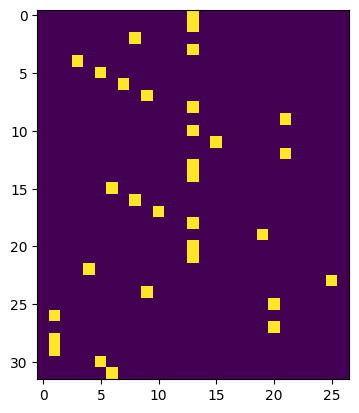

In [23]:
plt.imshow(F.one_hot(logits.max(1).indices, num_classes=logits.shape[1]));

In [37]:
dlogit_maxes.shape

torch.Size([32, 1])

In [24]:
dlogits += F.one_hot(logits.max(1).indices, num_classes=logits.shape[1]) * dlogit_maxes

In [40]:
compare('logits', dlogits, logits)

logits          | exact: True  | approximate: True  | maxdiff: 0.0


**`h, W2 and B2`**

In [41]:
dlogits.shape, h.shape, W2.shape, B2.shape

(torch.Size([32, 27]),
 torch.Size([32, 64]),
 torch.Size([64, 27]),
 torch.Size([27]))

In [25]:
dh = dlogits @ W2.T
dW2 = h.T @ dlogits
dB2 = dlogits.sum(0)

In [43]:
compare('h', dh, h)
compare('W2', dW2, W2)
compare('B2', dB2, B2)

h               | exact: True  | approximate: True  | maxdiff: 0.0
W2              | exact: True  | approximate: True  | maxdiff: 0.0
B2              | exact: True  | approximate: True  | maxdiff: 0.0


**`hpreact`**

In [26]:
dhpreact = (1.0 - h**2) * dh

In [47]:
compare('hpreact', dhpreact, hpreact)

hpreact         | exact: True  | approximate: True  | maxdiff: 0.0


In [45]:
hpreact.shape, bngain.shape, bnraw.shape, bnbias.shape

(torch.Size([32, 64]),
 torch.Size([1, 64]),
 torch.Size([32, 64]),
 torch.Size([1, 64]))

**`bngain, bnraw and bnbias`**

In [27]:
dbngain = (bnraw * dhpreact).sum(0, keepdim=True)
dbnraw = bngain * dhpreact
dbnbias = dhpreact.sum(0, keepdim=True)

In [49]:
compare('bngainh', dbngain, bngain)
compare('bnraw', dbnraw, bnraw)
compare('bnbias', dbnbias, bnbias)

bngainh         | exact: True  | approximate: True  | maxdiff: 0.0
bnraw           | exact: True  | approximate: True  | maxdiff: 0.0
bnbias          | exact: True  | approximate: True  | maxdiff: 0.0


**`bndiff and bnvar_inv`**

In [51]:
bnraw.shape, bndiff.shape, bnvar_inv.shape

(torch.Size([32, 64]), torch.Size([32, 64]), torch.Size([1, 64]))

In [38]:
dbndiff = bnvar_inv * dbnraw
dbnvar_inv = (bndiff * dbnraw).sum(0, keepdim=True)

In [56]:
compare('bndiff', dbndiff, bndiff) # expected to be false because we haven't calucated it completely
compare('bnvar_inv', dbnvar_inv, bnvar_inv)

bndiff          | exact: False | approximate: False | maxdiff: 0.0009200623608194292
bnvar_inv       | exact: True  | approximate: True  | maxdiff: 0.0


**`bnvar`**

In [29]:
dbnvar = (-0.5*(bnvar + 1e-5)**-1.5) * dbnvar_inv

In [58]:
compare('bnvar', dbnvar, bnvar)

bnvar           | exact: True  | approximate: True  | maxdiff: 0.0


## Bessel's Correction

In the batch norm layer there are two ways to get the variance in a tensor. First is the biased estimate in which we perform `1/n` and the other is `1/(n-1)`. In paper in which they use the biased version during training and the unbiased version during inference.

Dividing by `n-1` gives a better estimate of the variance in cases where the sample sizes are very small like in the case of our batches. Estimating using `1/n` almost always underestimates the variance hence it's advised to use the unbiased estimator.

## Backprop (Contd.)

**`bndiff2`**

In [30]:
bnvar.shape, bndiff2.shape

(torch.Size([1, 64]), torch.Size([32, 64]))

In [31]:
dbndiff2 = (1.0 / (n-1)) * torch.ones_like(bndiff2) * dbnvar

In [32]:
compare('bndiff2', dbndiff2, bndiff2)

bndiff2         | exact: True  | approximate: True  | maxdiff: 0.0


**`bndiff`**

In [39]:
dbndiff += (2*bndiff) * dbndiff2 # gradient of second branch for bndiff

In [40]:
compare('bndiff', dbndiff, bndiff)

bndiff          | exact: True  | approximate: True  | maxdiff: 0.0


**`hprebn and bnmeani`**

In [41]:
bndiff.shape, hprebn.shape, bnmeani.shape

(torch.Size([32, 64]), torch.Size([32, 64]), torch.Size([1, 64]))

In [44]:
dhprebn = dbndiff.clone()
dbnmeani = (-dbndiff).sum(0) # -torch.ones_like(bndiff) * dbndiff = dbndiff

In [45]:
compare('hprebn', dhprebn, hprebn) # expected to be incorrect because there is a second branch
compare('bnmeani', dbnmeani, bnmeani)

hprebn          | exact: False | approximate: False | maxdiff: 0.0018582979682832956
bnmeani         | exact: True  | approximate: True  | maxdiff: 0.0


In [46]:
dhprebn +=  (1.0/n) * (torch.ones_like(hprebn) * dbnmeani)

In [47]:
compare('hprebn', dhprebn, hprebn) # we have added the second branch of the gradient

hprebn          | exact: True  | approximate: True  | maxdiff: 0.0


In [49]:
hprebn.shape, embcat.shape, W1.shape, B1.shape

(torch.Size([32, 64]),
 torch.Size([32, 30]),
 torch.Size([30, 64]),
 torch.Size([64]))

**`embcat, W1 and B1`**

In [50]:
dembcat = dhprebn @ W1.T
dW1 = embcat.T @ dhprebn
dB1 = dhprebn.sum(0)

In [51]:
compare('embcat', dembcat, embcat)
compare('W1', dW1, W1)
compare('B1', dB1, B1)

embcat          | exact: True  | approximate: True  | maxdiff: 0.0
W1              | exact: True  | approximate: True  | maxdiff: 0.0
B1              | exact: True  | approximate: True  | maxdiff: 0.0


**`emb`**

In [52]:
embcat.shape, emb.shape

(torch.Size([32, 30]), torch.Size([32, 3, 10]))

In [53]:
demb = dembcat.view(emb.shape)

In [54]:
compare('emb', demb, emb)

emb             | exact: True  | approximate: True  | maxdiff: 0.0


**`C`**

In [55]:
emb.shape, C.shape, Xb.shape

(torch.Size([32, 3, 10]), torch.Size([27, 10]), torch.Size([32, 3]))

In [56]:
dC = torch.zeros_like(C)
for k in range(Xb.shape[0]):
    for j in range(Xb.shape[1]):
        ix = Xb[k,j]
        dC[ix] += demb[k,j]

In [57]:
compare('C', dC, C)

C               | exact: True  | approximate: True  | maxdiff: 0.0


## Backprop Through Simplified Forward Pass(Loss Function)

Earlier, we used a lot of intermediate tensors just to form a basic understanding of step by step backprop. When we look at the mathematical expression for the loss and perform the differentiation then a lot of terms cancel out and we get a simplified expression which is significantly easier to backprop through.

In [58]:
loss_fast = F.cross_entropy(logits, Yb)

In [59]:
print(loss_fast.item(), 'diff: ', (loss_fast - loss).item())

3.3032257556915283 diff:  2.384185791015625e-07


We'll differentiate the mathematical form of `cross_entropy` to get a simplified equation.

In [60]:
dlogits = F.softmax(logits, 1) # softmax across the rows
dlogits[range(n), Yb] -= 1
dlogits /= n

In [63]:
compare('logits', dlogits, logits)

logits          | exact: False | approximate: True  | maxdiff: 6.51925802230835e-09


We don't get an exact match (because of how floating point numbers work) but the maximum difference is negligible.

### What Does `dlogits` Represent

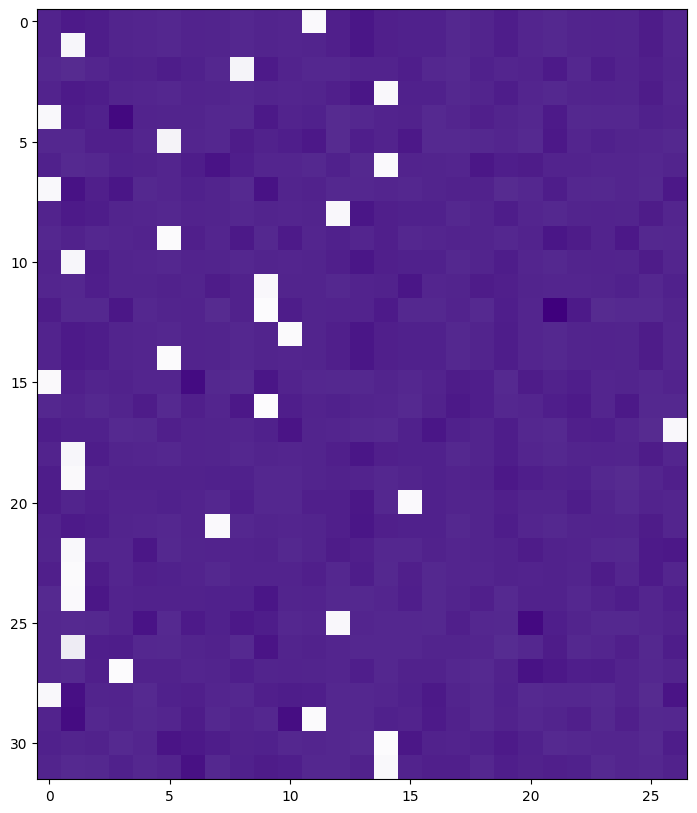

In [71]:
plt.figure(figsize=(10,10))
plt.imshow(dlogits.detach(), cmap='Purples');

`dlogits` is the gradient of the probability matrix in the forward pass. The white squares represent the correct character indices where we subtracted 1.

Looking at the first row we have:

In [72]:
F.softmax(logits, 1)[0]

tensor([0.0347, 0.0640, 0.0560, 0.0295, 0.0239, 0.0213, 0.0365, 0.0309, 0.0222,
        0.0281, 0.0259, 0.0300, 0.0476, 0.0854, 0.0464, 0.0429, 0.0459, 0.0154,
        0.0319, 0.0583, 0.0263, 0.0165, 0.0290, 0.0328, 0.0295, 0.0633, 0.0257],
       grad_fn=<SelectBackward0>)

In [73]:
dlogits[0] * n

tensor([ 0.0347,  0.0640,  0.0560,  0.0295,  0.0239,  0.0213,  0.0365,  0.0309,
         0.0222,  0.0281,  0.0259, -0.9700,  0.0476,  0.0854,  0.0464,  0.0429,
         0.0459,  0.0154,  0.0319,  0.0583,  0.0263,  0.0165,  0.0290,  0.0328,
         0.0295,  0.0633,  0.0257], grad_fn=<MulBackward0>)

This gives us the exact probabilities except at the correct index which is appx -1.

In [74]:
dlogits[0].sum() # This sums to 0 

tensor(-6.9849e-10, grad_fn=<SumBackward0>)

So because we update our params by `-lr * grads` we are decreasing the probs at the incorrect indices and increasing at the correct index. The amount of this increase and increase is exactly even as shown by the `sum = 0`. The amount of increase/ decrease is proportional to the probs. 